In [312]:
# download the file 'problem_set_1_data.csv'
# and the execute this cell

import pandas as pd
data = pd.read_csv('problem_set_1_data.csv')
data

,group,outcome,x1,x2
0,1,True,14.510771,19.431799
1,0,False,11.404356,3.332700
2,1,False,10.526163,4.323102
3,1,True,10.841790,21.453620
4,0,False,-1.902080,-10.871900
...,...,...,...,...
19995,1,False,8.816086,10.895516
19996,1,False,10.790022,4.843957
19997,0,False,12.043766,5.087219
19998,1,True,22.548743,17.227402


For this problem we’ll use the toy dataset ``problem_set_1_data.csv`. Each row represents a person belonging to one of two demographic groups, denoted by the binary group variable. The task is to predict the binary out­come variable using the continuous features $x_1$ and $x_2$, and possibly also using group.

Given a classifier $f$ and a dataset $D$, let’s define the demographic disparity of the classifier as the absolute difference in the probability of positive classification for the two groups:

$$ |P(\hat Y = 1|X\in G^+) - P(\hat Y = 1|X\in G^-)|$$

Disparity varies from 0 to 1. If it is 0, we say that the classifier satisfies demographic parity.

**Notes and hints**:
+ Partition the data into training and validation sets, and report all accuracies and disparities on the validation set. You might want to use k-fold cross validation.
+ Report any regularization parameter that you used for logistic regression.
+ The choice of ML library, etc. is up to you.


1. Train a logistic regression classifier to predict outcome given $x_1$ and $x_2$. Report its accuracy and demographic disparity. Accuracy refers to the fraction of instances classified correctly.

In [255]:
import numpy as np

class LogRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.losses = []
         
    #Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    def feed_forward(self,X):
        z = np.dot(X, self.weights)
        A = self._sigmoid(z)
        return A

    def fit(self, X_, y):
        X = np.hstack([np.ones((X_.shape[0], 1)), X_]) # use a stacked column of 1s to use as bias
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)

        # gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            self.losses.append(self.compute_loss(y,A))
            dz = A - y # derivative of sigmoid and bce X.T*(A-y)
            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, dz)
            # update parameters
            self.weights -= self.lr * dw
            
    def predict(self, X_):
        X = np.hstack([np.ones((X_.shape[0], 1)), X_])
        threshold = .5
        y_hat = np.dot(X, self.weights)
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        
        return np.array(y_predicted_cls)

    


In [256]:
from sklearn.model_selection import train_test_split
X = data.loc[:, ("group","x1", "x2")].values
y = data.loc[:, ("outcome")].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

# Save the groups
X_train_g = X_train[:,0]
X_train = X_train[:,1:]
X_test_g = X_test[:,0]
X_test = X_test[:,1:]

clf = LogRegression(n_iters=10000, learning_rate=0.01)

clf.fit(X_train, y_train)

In [257]:
from sklearn.metrics import accuracy_score
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {0:.3f}".format(accuracy))

Test accuracy: 0.728


In [258]:
# Let's split the test data into the two groups
g0_i = X_test_g == 0
g1_i = X_test_g == 1

X_test_g0 = X_test[g0_i]
y_test_g0 = y_test[g0_i]
X_test_g1 = X_test[g1_i]
y_test_g1 = y_test[g1_i]

predictions = clf.predict(X_test_g0)
p_i_g0 = np.sum(predictions == 1)/predictions.shape[0]
print("P(Y=1) for group 0: {0:.3f}".format(p_i_g0))

predictions = clf.predict(X_test_g1)
p_i_g1 = np.sum(predictions == 1)/predictions.shape[0]
print("P(Y=1) for group 1: {0:.3f}".format(p_i_g1))

disparity = np.abs(p_i_g0 - p_i_g1)
print("Disparity: {0:.3f}".format(disparity))

P(Y=1) for group 0: 0.411
P(Y=1) for group 1: 0.601
Disparity: 0.190


2. One of the features $x_1$ and $_2$ is a proxy for group membership (i.e., it correlates with group). Which feature is it? Train a classifier without that feature (i.e., using only a single feature). Report the accuracy and demographic disparity.

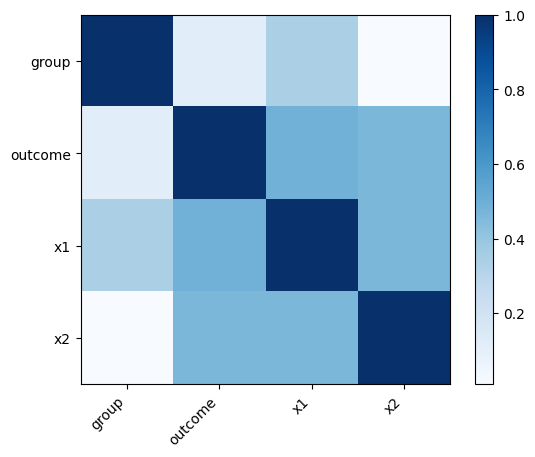

In [259]:
import matplotlib.pyplot as plt
from sklearn import datasets  
import pandas as pd 
matrix = data.corr()

#plotting correlation matrix 
plt.imshow(matrix, cmap='Blues')

#adding colorbar 
plt.colorbar()

#extracting variable names 
variables = []
for i in matrix.columns:
  variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

We can se that x1 is correlated to the group, a proxy variable

In [261]:
X = data.loc[:, ("group", "x2")].values
y = data.loc[:, ("outcome")].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

# Save the groups
X_train_g = X_train[:,0]
X_train = X_train[:,1:]
X_test_g = X_test[:,0]
X_test = X_test[:,1:]

clf = LogRegression(n_iters=10000, learning_rate=0.01)

clf.fit(X_train, y_train)

In [262]:
from sklearn.metrics import accuracy_score
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {0:.3f}".format(accuracy))

Test accuracy: 0.686


In [263]:
# Let's split the test data into the two groups
g0_i = X_test_g == 0
g1_i = X_test_g == 1

X_test_g0 = X_test[g0_i]
y_test_g0 = y_test[g0_i]
X_test_g1 = X_test[g1_i]
y_test_g1 = y_test[g1_i]

predictions = clf.predict(X_test_g0)
p_i_g0 = np.sum(predictions == 1)/predictions.shape[0]
print("P(Y=1) for group 0: {0:.3f}".format(p_i_g0))

predictions = clf.predict(X_test_g1)
p_i_g1 = np.sum(predictions == 1)/predictions.shape[0]
print("P(Y=1) for group 1: {0:.3f}".format(p_i_g1))

disparity = np.abs(p_i_g0 - p_i_g1)
print("Disparity: {0:.3f}".format(disparity))

P(Y=1) for group 0: 0.497
P(Y=1) for group 1: 0.506
Disparity: 0.009


Without the proxy variable x1 we see that the disparity is almost gone, but the accuracy also goes down to 68% from the previous 72%.

3. Suppose we wish to achieve a tunable tradeoff between accuracy and demographic disparity. One way to do this is to add a term to the loss function that measures the disparity of $f$. Write a formula for such a loss function term and explain it.

**Notes and hints**:
The training set disparity is a good start, but it is tough to optimize because it has discontinuities when a training point falls on the decision boundary. Can you come up with a continuous analog of the training set disparity?

ANSWER: $Loss = -\frac{1}{N}\sum_{k \in X} [y_k\log (p_k) + (1-y_k) \log (1-p_k)] + \gamma | P(\hat Y=1 | X \in G^+) - P(\hat Y=1 | X \in G^-)|$

where $\gamma$ is the tunable hyperparameter for the demographic disparity

To compare between the two probability distributions I assumed that both were binomial distributions were the probabilities p and q represent the probability of success (Y=1). I also had to use the [KL divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) to measure the difference between the distributions:

$$
D_{KL} (p || q) = p \log \left(\frac{p}{q}\right) + (1-p)\log \left(\frac{1-p}{1-q}\right)
$$

where p and q:

$$
p = \frac{1}{N_{G^+}}\sum_{k \in G^+} \sigma (k) \\
q = \frac{1}{N_{G^-}}\sum_{k \in G^-} \sigma (k)
$$

To compute this loss I opted to use the numerical gradient instead of the analytic one because I wasn't able to properly differentiate it. The first few tries didn't converge or wasn't affected by the gamma strength.

4. Train a model with this loss function.  Gradually vary the strength of this disparity term in the loss function and optimize the resulting loss function each time. Use this to plot a curve showing the achievable tradeoff between accuracy (on the $y$-axis) and disparity (on the $x$-axis).

**Notes and hints**:
When the disparity strength is 0, you should recover the accuracy that you reported for part (1).




In [295]:
class LogRegressionDisparity:
    def __init__(self, learning_rate=0.001, n_iters=1000, disparity_strength = 1.):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.losses = []
        self.ds = disparity_strength
        self.threshold = .5
        self._coeffs_hist = list()
         
    #Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred, groups):
        bce = self.bce_loss(y_true, y_pred)
        disparity = self.disparity_term(y_pred, groups)
        loss = bce + self.ds * disparity
        return loss

    def bce_loss(self, y_true, y_pred):
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)
    
    def disparity_term(self, y_pred, groups):
        g0 = y_pred[groups == 0]
        g1 = y_pred[groups == 1]
        if len(g0) == 0 or len(g1) == 0: 
            return 0.0
        
        g0_mean = np.mean(g0)
        g1_mean = np.mean(g1)
        # Measure the difference between the binomial distributions
        return g0_mean*np.log(g0_mean/g1_mean)+(1-g0_mean)*np.log((1-g0_mean)/(1-g1_mean))
    
    def feed_forward(self,X, w):
        z = np.dot(X, w)
        A = self._sigmoid(z)
        return A

    def fit(self, X_, y, groups):
        X = np.hstack([np.ones((X_.shape[0], 1)), X_]) # use a stacked column of 1s to use as bias
        _, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        nweights = self.weights.shape[0]

        # gradient descent
        for i in range(self.n_iters):

            # I opted to use the numerical gradient by checking the individual 
            # partial derivatives of each weight
            h = 1e-4
            grad = np.zeros(nweights)
            for w in range(nweights):
                w_add = np.copy(self.weights)
                w_sub = np.copy(self.weights)
                w_add[w] += h
                w_sub[w] -= h
                w_add = self.feed_forward(X, w_add)
                w_sub = self.feed_forward(X, w_sub)
                w_add = self.compute_loss(y, w_add, groups)
                w_sub = self.compute_loss(y, w_sub, groups)
                grad[w] = (w_add-w_sub)/(2*h)
                
            self.losses.append(w_add)

            self.weights -= self.lr * grad

            self._coeffs_hist.append(np.copy(self.weights)) # save the history of coefficients for a later exercise
            if (i+1) % (self.n_iters//10) == 0:
                print(f"Iter {i+1}/{self.n_iters}, loss {self.losses[-1]}")
            
    def predict(self, X_):
        X = np.hstack([np.ones((X_.shape[0], 1)), X_])
        y_hat = np.dot(X, self.weights)
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > self.threshold else 0 for i in y_predicted]
        
        return np.array(y_predicted_cls)

    


In [311]:
def disparity_score(groups, X, clf, verbose=True):
    # Let's split the test data into the two groups
    g0_i = groups == 0
    g1_i = groups == 1

    X_g0 = X[g0_i]
    X_g1 = X[g1_i]

    predictions = clf.predict(X_g0)
    p_i_g0 = np.sum(predictions == 1)/predictions.shape[0]

    predictions = clf.predict(X_g1)
    p_i_g1 = np.sum(predictions == 1)/predictions.shape[0]

    disparity = np.abs(p_i_g0 - p_i_g1)
    if verbose: 
        print("P(Y=1) for group 0: {0:.3f}".format(p_i_g0))
        print("P(Y=1) for group 1: {0:.3f}".format(p_i_g1))
        print("Disparity: {0:.3f}".format(disparity))
    else:
        return disparity

In [298]:
X = data.loc[:, ("group","x1", "x2")].values
y = data.loc[:, ("outcome")].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)
# Save the groups
X_train_g = X_train[:,0]
X_train = X_train[:,1:]
X_test_g = X_test[:,0]
X_test = X_test[:,1:]

clfs = list()
for gamma in [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]:
    print("="*100)
    print(f"Model with gamma = {gamma}")
    clf = LogRegressionDisparity(n_iters=10000, learning_rate=0.01, disparity_strength=gamma)
    clf.fit(X_train, y_train, X_train_g)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Test accuracy: {0:.3f}".format(accuracy))
    disparity_score(X_test_g, X_test, clf)
    clfs.append(clf)

Model with gamma = 0.0
Iter 1000/10000, loss 0.5590782108042184
Iter 2000/10000, loss 0.5297552388587718
Iter 3000/10000, loss 0.5180742227210348
Iter 4000/10000, loss 0.5127803767068326
Iter 5000/10000, loss 0.5101824104415682
Iter 6000/10000, loss 0.5088399323576727
Iter 7000/10000, loss 0.5081215639173327
Iter 8000/10000, loss 0.5077276646681596
Iter 9000/10000, loss 0.507507876567421
Iter 10000/10000, loss 0.5073836712564442
Test accuracy: 0.728
P(Y=1) for group 0: 0.411
P(Y=1) for group 1: 0.601
Disparity: 0.190
Model with gamma = 0.01
Iter 1000/10000, loss 0.5592436236938798
Iter 2000/10000, loss 0.529977446012214
Iter 3000/10000, loss 0.5183218717483566
Iter 4000/10000, loss 0.513040457031209
Iter 5000/10000, loss 0.510448992122708
Iter 6000/10000, loss 0.5091100801629701
Iter 7000/10000, loss 0.5083937337096028
Iter 8000/10000, loss 0.5080010077692823
Iter 9000/10000, loss 0.5077819116567631
Iter 10000/10000, loss 0.5076581191377246
Test accuracy: 0.728
P(Y=1) for group 0: 0.41

In this exercise I noticed that the model can achieve a good balance between accuracy and disparity at $\gamma=10.0$, with an accuracy of 0.702 and disparity of 0.048 

5. Repeat part (4), but with group as an additional feature (i.e., train a classifier to predict outcome based on $x_1$, $x_2$, and $group$, using the modified loss function).


In [299]:
X = data.loc[:, ("group","x1", "x2")].values
y = data.loc[:, ("outcome")].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)
# Save the groups
X_train_g = X_train[:,0]
X_test_g = X_test[:,0]

clfs_2 = list()
for gamma in [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]:
    print("="*100)
    print(f"Model with gamma = {gamma}")
    clf = LogRegressionDisparity(n_iters=10000, learning_rate=0.01, disparity_strength=gamma)
    clf.fit(X_train, y_train, X_train_g)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Test accuracy: {0:.3f}".format(accuracy))
    disparity_score(X_test_g, X_test, clf)
    clfs_2.append(clf)

Model with gamma = 0.0
Iter 1000/10000, loss 0.5560226856745661
Iter 2000/10000, loss 0.5292338133950463
Iter 3000/10000, loss 0.5186457607222121
Iter 4000/10000, loss 0.5136153570378038
Iter 5000/10000, loss 0.5109582471547379
Iter 6000/10000, loss 0.5094621924466104
Iter 7000/10000, loss 0.508585425263547
Iter 8000/10000, loss 0.5080580133709094
Iter 9000/10000, loss 0.5077351239454391
Iter 10000/10000, loss 0.5075350104576194
Test accuracy: 0.727
P(Y=1) for group 0: 0.423
P(Y=1) for group 1: 0.587
Disparity: 0.165
Model with gamma = 0.01
Iter 1000/10000, loss 0.5560549739065377
Iter 2000/10000, loss 0.5293005233122104
Iter 3000/10000, loss 0.518746413329112
Iter 4000/10000, loss 0.5137476915525272
Iter 5000/10000, loss 0.5111180346893918
Iter 6000/10000, loss 0.5096443373417584
Iter 7000/10000, loss 0.5087849728306618
Iter 8000/10000, loss 0.5082706740311383
Iter 9000/10000, loss 0.5079574343739237
Iter 10000/10000, loss 0.5077642981290205
Test accuracy: 0.727
P(Y=1) for group 0: 0.

Here we can see that the accuracy has stayed on the 71-73% even with large gammas, more surprisingly the disparity has gone down to 0.004.

6.  In parts (4) and (5), how do the coefficients of $x_1$, $x_2$, and $group$ change as the strength of the disparity term in the loss function increases? Give an intuitive explanation for why the coefficients change the way they do.


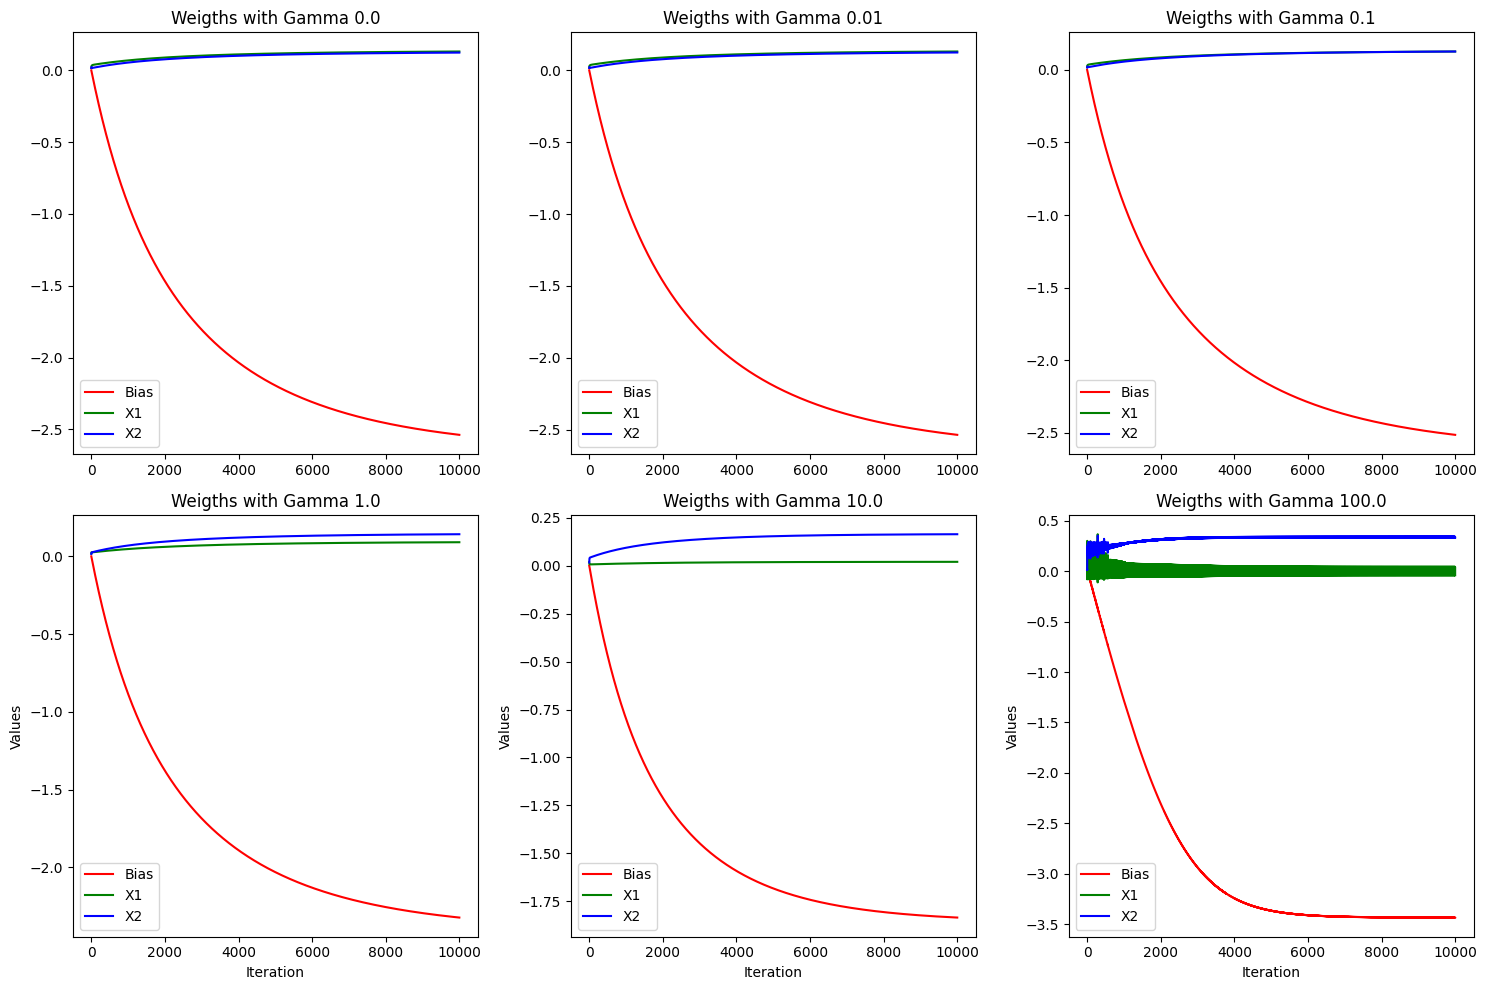

In [309]:
import numpy as np
import matplotlib.pyplot as plt

# Define the layout of subplots
num_rows = 2
num_cols = 3

# Create a new figure
plt.figure(figsize=(15, 10))

gammas = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
# Loop through each subplot position
for i in range(num_rows * num_cols):
    # Determine subplot position (1-indexed)
    subplot_index = i + 1
    
    # Add a subplot to the current figure
    plt.subplot(num_rows, num_cols, subplot_index)
    
    # Plot the three lines in the current subplot
    plt.plot(np.array(clfs[i]._coeffs_hist)[:, 0], label='Bias', color='red')
    plt.plot(np.array(clfs[i]._coeffs_hist)[:, 1], label='X1', color='green')
    plt.plot(np.array(clfs[i]._coeffs_hist)[:, 2], label='X2', color='blue')
    
    # Add legend to the subplot
    plt.legend()
    
    # Set subplot title
    plt.title(f'Weigths with Gamma {gammas[i]}')
    
    # Add labels to the axes only for the last row of subplots
    if i >= num_cols * (num_rows - 1):
        plt.xlabel('Iteration')
        plt.ylabel('Values')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the figure with all subplots
plt.show()

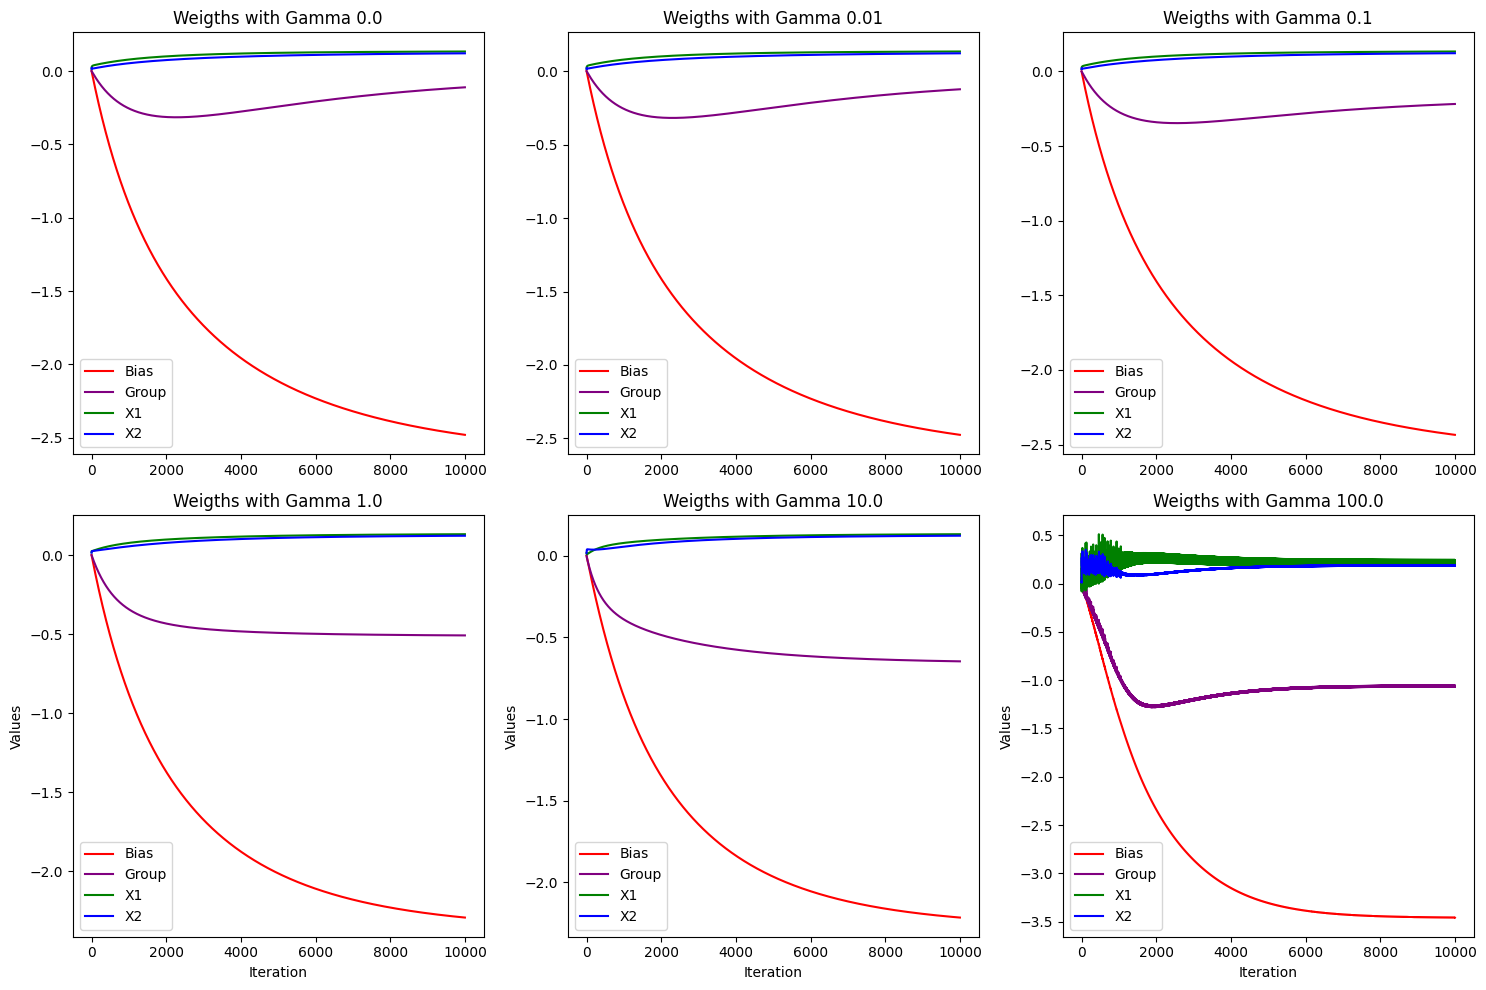

In [327]:
# Define the layout of subplots
num_rows = 2
num_cols = 3

# Create a new figure
plt.figure(figsize=(15, 10))

gammas = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
# Loop through each subplot position
for i in range(num_rows * num_cols):
    # Determine subplot position (1-indexed)
    subplot_index = i + 1
    
    # Add a subplot to the current figure
    plt.subplot(num_rows, num_cols, subplot_index)
    
    # Plot the three lines in the current subplot
    plt.plot(np.array(clfs_2[i]._coeffs_hist)[:, 0], label='Bias', color='red')
    plt.plot(np.array(clfs_2[i]._coeffs_hist)[:, 1], label='Group', color='purple')
    plt.plot(np.array(clfs_2[i]._coeffs_hist)[:, 2], label='X1', color='green')
    plt.plot(np.array(clfs_2[i]._coeffs_hist)[:, 3], label='X2', color='blue')
    
    # Add legend to the subplot
    plt.legend()
    
    # Set subplot title
    plt.title(f'Weigths with Gamma {gammas[i]}')
    
    # Add labels to the axes only for the last row of subplots
    if i >= num_cols * (num_rows - 1):
        plt.xlabel('Iteration')
        plt.ylabel('Values')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the figure with all subplots
plt.show()

ANSWER: The bias doesn't matter too much because it's just the displacement of the boundary. For the weights for x1 and x2, it seems that the model gives progressively more importance to x2 since x1 is a proxy variable that perpetuates the disparity between the groups as we saw before. For the weight for group, similarly to x2 it decreases in importance but x2 and x1 stay on the same ranges.

7. Comparing your accuracy-vs-disparity curves in parts (4) and (5), which option gives a better tradeoff: using $group$ or not using $group$?


In [317]:
X = data.loc[:, ("group","x1", "x2")].values
y = data.loc[:, ("outcome")].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)
# Save the groups
X_train_g = X_train[:,0]
X_train = X_train[:,1:]
X_test_g = X_test[:,0]
X_test = X_test[:,1:]

data_1 = []
for i in range(6):
    predictions = clfs[i].predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    disparity = disparity_score(X_test_g, X_test, clfs[i], verbose=False)
    data_1.append([accuracy, disparity])

X = data.loc[:, ("group","x1", "x2")].values
y = data.loc[:, ("outcome")].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)
# Save the groups
X_train_g = X_train[:,0]
X_test_g = X_test[:,0]

data_2 = []
for i in range(6):
    predictions = clfs_2[i].predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    disparity = disparity_score(X_test_g, X_test, clfs_2[i], verbose=False)
    data_2.append([accuracy, disparity])

data_1 = np.array(data_1)
data_2 = np.array(data_2)

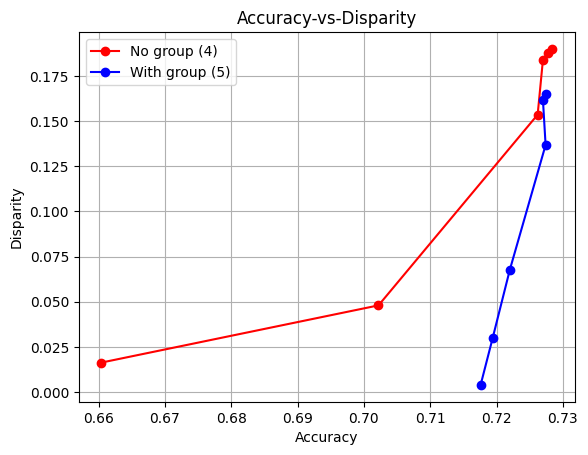

In [328]:
data_1.shape
plt.plot(data_1[:,0], data_1[:,1], label='No group (4)', color='red', marker='o')
plt.plot(data_2[:,0], data_2[:,1], label='With group (5)', color='Blue', marker='o')
plt.xlabel('Accuracy')
plt.ylabel('Disparity')
plt.title('Accuracy-vs-Disparity')
plt.legend()
plt.grid(True)
plt.show()

ANSWER: With no doubt the better tradeoff and overall values are for the model using the group variable (5), as the worst accuracy is still over 70% and with a disparity of 0.004.

8. Describe a decision-making scenario that might have led to this toy problem. Specifically, state what the outcome, $x_1$, $x_2$, and $group$ variables are. In this scenario, describe which classifier (if any) would you use and what factors would you consider in making your choice.


ANSWER: A decision-making scenario that fits to this toy problem is a loan approval decision. In this case we can map the variables as such:

- **Outcome:** Whether a loan application is approved.
- **Group:** Several groups could fit in this problem, for this example I'll use whether the applicant is white or non-white.
- **X1, X2:** Here we could take different approaches on what each of the variables mean, we could say for example x2 is the employment status, and x1 represents the income level. As we saw before x1 is a proxy variable for the group, and in this case the systematic racism has created a situation where on average non-white people have less income level, thus being a correlated variable with the group.

In this scenario, the reduction of disparity is at most important to not perpetuate the systemic biases that are present in our data and world. I would use the classifier with less disparity, with an acceptable accuracy; so the classifier used would be the logistic regression with the disparity term with gamma 100 fitted with all 3 variables (x1, x2, group). An important factor to consider is that we are using a protected group for the classifier (race), meaning that we have to be careful and monitor the classifiers closely.